In [6]:
# -------------------------------
# Libraries
# -------------------------------
%matplotlib inline
from time import time
import matplotlib.pylab as plt
import os.path
from math import *
import numpy as np
from tramway.helper import *
from tramway.helper.simulation import *
from tramway.helper.tessellation import *
from tramway.helper.inference import *
from tramway.plot.mesh import plot_delaunay
from numpy.random import seed
#from scipy.stats import skellam
#from scipy.optimize import fmin,minimize

#--------------------------------
# Functions
#--------------------------------
def D_field(r,t):
    '''Defining the diffusivity field: Gaussian in space, constant in time.'''
    return D - (D-D0)*np.exp(-np.sum((r/r_scale-mu_r)**2)/sig_r) 

def new_tracers(t):
    '''Number of tracers to appear in each frame n ~ Poisson(mu_on).'''
    return np.random.poisson(mu_on)

def inner_cells(cells_):
    indices = cells_.tessellation.cell_vertices
    vertices = cells_.tessellation.vertices
    cells_to_include = []
    for i in range(len(indices)):
        cells_to_include.append( not ((vertices[indices[i]]<=0)|(vertices[indices[i]]>=r_scale)).any() )
    return cells_to_include

#--------------------------------
# Constants and parameters:
#--------------------------------
# Tesselation method and name:
tessellation_method = 'hexagon'
mesh_label = '{}'.format(tessellation_method) #, location_count, min_location_count)
min_loc_count = 0
# Optimization parameters:
nt_method = ('nT_test02_hex', 'NM')
tol = 1e-2

# Normalized placement and with of diffusivity well:
mu_r=np.array([0.5,0.5]) 
sig_r=0.05
# Size of the bounding box:
r_scale = 10. # [um]
# Reference distance to set mesh size:
ref_distance = 1. # [mu]

# baseline diffusivity:
D = 0.5 # [um^2.s^-1]
# diffusivity at the bottom of the sink:
D0 = 0.05 # [um^2.s^-1]
# number of trajectories:
M = 100
# time step:
dt = 0.05 # [s]
# average trajectory lifetime (+ p_off and mu_on):
tau = 0.2
p_off = dt/tau
mu_on = p_off*M
# Simulation duration:
T = 1.0 # [s]
# position noise:
sigma = 0. # [um]
# Number of ensembles to test:
Q = 1


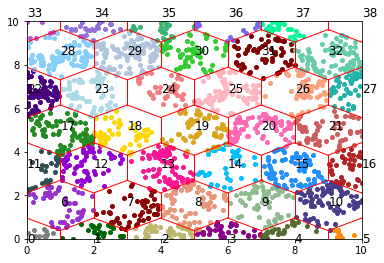

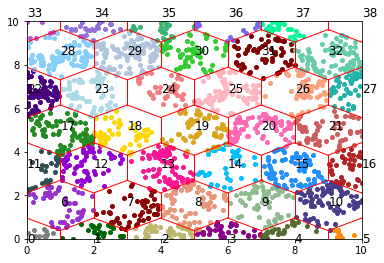

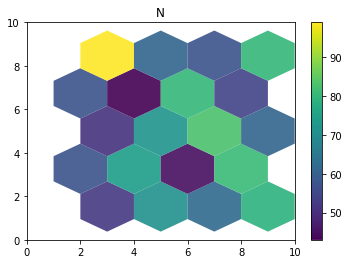

In [7]:
#--------------------------------
# Simulate:
#--------------------------------
seed(1234567890)
## generate the trajectories
q=0

data_nxyt = random_walk(diffusivity=D_field, duration=T, lifetime_tau=tau, single=True, reflect=True, 
                  trajectory_mean_count=M, box=[0.,0.,r_scale,r_scale], )
data_nxyt = data_nxyt.dropna()
data_xyt = data_nxyt.drop('n',axis=1)

# tesselate for trajectories:
cells_nxyt = tessellate(data_nxyt, tessellation_method, ref_distance=ref_distance, min_location_count=0,
           strict_min_location_count=min_loc_count,
           force=True, output_label=mesh_label)
# tesselate for positions:
cells_xyt = tessellate(data_xyt, tessellation_method, ref_distance=ref_distance, min_location_count=0,
           strict_min_location_count=min_loc_count,
           force=True, output_label=mesh_label)

cells_to_include = inner_cells(cells_xyt)    
cells_xyt.tessellation.cell_label = np.array(cells_to_include)
cells_nxyt.tessellation.cell_label = np.array(cells_to_include)

## plot positions and tesselations:
cell_plot(cells_nxyt, cell_indices=True)
cell_plot(cells_xyt, cell_indices=True)
# Plot numbers of positions per cell:
map_plot((pd.DataFrame(cells_xyt.location_count, columns=['N'])),cells=cells_xyt) #,cmap='inferno') 

In [ ]:
# ------------------------------------------------
# infer in D mode without spatial regularization
# ------------------------------------------------
maps_nxyt = infer(cells_nxyt, 'D', 
             sigma=sigma, verbose=False)

print(maps_nxyt)

mode:      d
runtime:   0.024342060089111328
sigma:     0.0
variables: ['diffusivity']
maps:      <class 'pandas.core.frame.DataFrame'>


In [ ]:
# ------------------------------------------------
# infer using nontracking (D mode without spatial regularization only)
# ------------------------------------------------
fittime = time.time()
maps_xyt = infer(cells_xyt, nt_method[0], new_cell=Locations, dt=dt, p_off=p_off, mu_on=mu_on,
        method=nt_method[1], tol=tol)
print(time.time()-fittime, "s")


Cell no.: 7 , frames: 20
Inner cell: avg(N): 2.6 S: 3.4641016151377544 mu^2
Outer cells: avg(N): 10.1 , S: 13.856406460551018 mu^2
Possible links: 224 , avg(N): 12.7
 final_simplex: (array([[0.33273682, 0.26322998],
       [0.3280957 , 0.26155273],
       [0.33816406, 0.25980469]]), array([1168.05589986, 1168.0566293 , 1168.05844001]))
           fun: 1168.0558998599454
       message: 'Optimization terminated successfully.'
          nfev: 34
           nit: 17
        status: 0
       success: True
             x: array([0.33273682, 0.26322998])
888.1179189682007 s

Cell no.: 8 , frames: 20
Inner cell: avg(N): 3.55 S: 3.4641016151377544 mu^2
Outer cells: avg(N): 11.65 , S: 17.32050807568877 mu^2
Possible links: 270 , avg(N): 15.2
 final_simplex: (array([[0.32538452, 0.22134888],
       [0.32658203, 0.21912109],
       [0.33502441, 0.22429199]]), array([1561.87414995, 1561.87567241, 1561.88172069]))
           fun: 1561.8741499536086
       message: 'Optimization terminated successfu

In [ ]:
centers = cells_nxyt.tessellation.cell_centers
D_true = pd.DataFrame([D_field(c_,0.) for c_ in centers],columns=['D'])
maps_true = Maps(D_true)
map_plot(maps_true, cells=cells_nxyt, title=False, cmap='inferno', clim=[0,1])
map_plot(maps_true, cells=cells_nxyt, title=False, cmap='inferno', clim=[0,1], 
         output_file='map(D_true),D=[{D0},{D}],tau={tau},dt={dt},sig_r={sig_r},box={r_scale},T={T},M={M},r_cell={ref_distance},q={q}.png')

## plot the force
map_plot(maps_nxyt, cells=cells_nxyt, title=False, cmap='inferno',clim=[0,1])
map_plot(maps_nxyt, cells=cells_nxyt, title=False, cmap='inferno',clim=[0,1], 
         output_file='map(D_nxyt),D=[{D0},{D}],tau={tau},dt={dt},sig_r={sig_r},box={r_scale},T={T},M={M},r_cell={ref_distance},q={q}.png')

# other variables are 'diffusivity' and 'potential'

map_plot(maps_xyt, cells=cells_xyt, title=False, cmap='inferno',clim=[0,1])
map_plot(maps_xyt, cells=cells_xyt, title=False, cmap='inferno',clim=[0,1], 
         output_file='map(D_xyt),D=[{D0},{D}],tau={tau},dt={dt},sig_r={sig_r},box={r_scale},T={T},M={M},r_cell={ref_distance},q={q}.png')

maps_diffs = Maps(pd.DataFrame(maps_xyt.maps['D'] - maps_nxyt.maps['diffusivity'],columns=['D']))
c_lim = max([max(maps_xyt.maps['D']),-min(maps_xyt.maps['D'])])
map_plot(maps_diffs, cells=cells_xyt, title=False, cmap='seismic', clim=[-c_lim,c_lim])
map_plot(maps_diffs, cells=cells_xyt, title=False, cmap='seismic', clim=[-c_lim,c_lim],
         output_file='map(D_xyt-D_nxyt),D=[{D0},{D}],tau={tau},dt={dt},sig_r={sig_r},box={r_scale},T={T},M={M},r_cell={ref_distance},q={q}.png')


(array([2., 6., 3., 5., 2., 1., 0., 0., 0., 1.]),
 array([-0.63796726, -0.5342137 , -0.43046015, -0.32670659, -0.22295303,
        -0.11919948, -0.01544592,  0.08830763,  0.19206119,  0.29581475,
         0.3995683 ]),
 <a list of 10 Patch objects>)

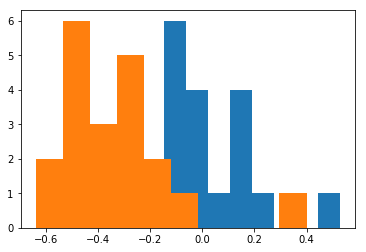

In [12]:
# bD_nxyt = (maps_nxyt['diffusivity']['diffusivity']-D_true['D'])/(D_true['D']*np.sqrt(2./cells_nxyt.location_count))
# bD_xyt = (maps_xyt['D']['D']-D_true['D'])/(D_true['D']*np.sqrt(2./cells_xyt.location_count))
bD_nxyt = (maps_nxyt['diffusivity']['diffusivity']-D_true['D'])/(D_true['D'])
bD_xyt = (maps_xyt['D']['D']-D_true['D'])/(D_true['D'])
plt.hist(bD_nxyt.dropna().values)
plt.hist(bD_xyt.dropna().values)

In [13]:
analysis_tree_nxyt = Analyses(data_nxyt)
analysis_tree_nxyt.add(cells_nxyt, label='mesh')
analysis_tree_nxyt['mesh'].add(maps_nxyt, label='diffusivity')
print(analysis_tree_nxyt['mesh']['diffusivity'].data.maps)
save_rwa(f'analyses_nxyt,D=[{D0},{D}],tau={tau},dt={dt},sig_r={sig_r},box={r_scale},T={T},M={M},r_cell={ref_distance},q={q}.rwa', analysis_tree_nxyt)

#maps_xyt = pd.read_csv('Estimates-1.txt', sep='\t', index_col=0, names=['diffusivity'])
analysis_tree_xyt = Analyses(data_xyt)
analysis_tree_xyt.add(cells_xyt, label='mesh')
analysis_tree_xyt['mesh'].add(maps_xyt, label='diffusivity')
print(analysis_tree_xyt['mesh']['diffusivity'].data.maps)
save_rwa(f'analyses_xyt,D=[{D0},{D}],tau={tau},dt={dt},sig_r={sig_r},box={r_scale},T={T},M={M},r_cell={ref_distance},q={q}.rwa', analysis_tree_xyt)


    diffusivity
7      0.546566
8      0.440789
9      0.330401
10     0.448168
12     0.444738
13     0.272364
14     0.354244
15     0.444898
18     0.346109
19     0.076421
20     0.255489
21     0.515081
23     0.405196
24     0.331110
25     0.286320
26     0.514631
29     0.411726
30     0.323906
31     0.410725
32     0.466185
overwrite file 'analyses_nxyt,D=[0.05,0.5],tau=0.2,dt=0.05,sig_r=0.05,box=10.0,T=1.0,M=100,r_cell=1.0,q=0.rwa': [N/y] y
           D
7   0.332737
8   0.325385
9   0.215000
10  0.249219
12  0.291807
13  0.238750
14  0.230000
15  0.252803
18  0.264346
19  0.069980
20  0.152305
21  0.174375
23  0.220063
24  0.253037
25  0.205000
26  0.332978
29  0.303281
30  0.242500
31  0.273750
32  0.303125
overwrite file 'analyses_xyt,D=[0.05,0.5],tau=0.2,dt=0.05,sig_r=0.05,box=10.0,T=1.0,M=100,r_cell=1.0,q=0.rwa': [N/y] y


AttributeError: `exposes` required for type: <class 'module'>
In: analyses
    |- _data

In [ ]:
#--------------------------------
# Simulate:
#--------------------------------
seed(1234567890)
## generate the trajectories
Q=1
Ds_nxyt = []
bDs_nxyt = []
Ds_xyt = []
bDs_xyt = []
for q in range(Q):
    print(f"{q}/{Q}")
    nxyt = random_walk(diffusivity=D_field, duration=T, lifetime_tau=tau, single=True, reflect=True, 
                      trajectory_mean_count=M, box=[0.,0.,r_scale,r_scale], )
    nxyt = nxyt.dropna()
    # tesselate for trajectories:
    cells_nxyt = tessellate(nxyt, tessellation_method, ref_distance=ref_distance, min_location_count=0,
                strict_min_location_count=min_loc_count, force=True, output_label=mesh_label)
    # tesselate for positions:
    xyt = nxyt.drop('n',axis=1)
    cells_xyt = tessellate(xyt, tessellation_method, ref_distance=ref_distance, min_location_count=0,
                strict_min_location_count=min_loc_count, force=True, output_label=mesh_label)
    # ------------------------------------------------
    # infer in D mode without spatial regularization
    # ------------------------------------------------
    centers = cells_nxyt.tessellation.cell_centers
    D_true = pd.DataFrame([D_field(c_,0.) for c_ in centers],columns=['D'])
    
    maps_nxyt = infer(cells_nxyt, 'D', 
                 sigma=sigma, verbose=False)
    D_nxyt = maps_nxyt['diffusivity']['diffusivity']
    Ds_nxyt.append(D_nxyt)
    bD_nxyt = (D_nxyt-D_true['D'])/(D_true['D']*np.sqrt(2./cells_nxyt.location_count))
    bDs_nxyt.extend(bD_nxyt.dropna().values)
    
    maps_xyt = infer(cells_xyt, nt_method[0], new_cell=Locations, dt=dt, p_off=p_off, mu_on=mu_on,
                method=nt_method[1], tol=tol)
    D_xyt = maps_xyt['D']['D']
    Ds_xyt.append(D_xyt)
    bD_xyt = (D_xyt-D_true['D'])/(D_true['D']*np.sqrt(2./cells_xyt.location_count))
    bDs_xyt.extend(bD_xyt.dropna().values)


In [24]:
plt.hist(bDs_nxyt)
plt.hist(bDs_xyt)

NameError: name 'bDs_nxyt' is not defined

In [38]:
help(cell_plot)

Help on function cell_plot in module tramway.helper.tessellation:

cell_plot(cells, xy_layer=None, output_file=None, fig_format=None, show=None, verbose=False, figsize=None, dpi=None, location_count_hist=False, cell_dist_hist=False, location_dist_hist=False, aspect=None, delaunay=None, locations={}, voronoi=None, colors=None, title=None, cell_indices=None, segment=None, label=None, input_label=None, num=None, **kwargs)
    Partition plots.
    
    Plots a spatial representation of the tessellation and partition if data are 2D.
    
    Arguments:
        cells (str or CellStats or Analyses):
            Path to a *.rwa* file or :class:`~tramway.tessellation.CellStats`
            instance or analysis tree; files and analysis trees may require
            `label`/`input_label` to be defined.
    
        xy_layer ({None, 'delaunay', 'voronoi'}):
            Overlay Delaunay or Voronoi graph over the data points. For 2D data only.
            **Deprecated**! Please use `delaunay` and `v

In [29]:
xyt

<module 'tramway.core.xyt' from 'c:\\users\\chris\\owncloud\\random walks\\tramway\\tramway\\tramway\\core\\xyt.py'>

In [30]:
nxyt

,n,x,y,t
1,1.0,9.621012,3.923589,0.10
2,1.0,9.748770,3.869013,0.15
3,1.0,9.467042,3.534028,0.20
4,1.0,9.916552,3.391060,0.25
5,2.0,9.736785,6.038604,0.05
6,2.0,9.603332,5.903274,0.10
7,2.0,9.183815,5.891606,0.15
8,2.0,9.578124,6.215738,0.20
9,2.0,9.364033,6.473891,0.25
10,3.0,4.043354,4.068691,0.05


In [35]:
print(cells_xyt.points)

             x         y     t
1     9.621012  3.923589  0.10
2     9.748770  3.869013  0.15
3     9.467042  3.534028  0.20
4     9.916552  3.391060  0.25
5     9.736785  6.038604  0.05
6     9.603332  5.903274  0.10
7     9.183815  5.891606  0.15
8     9.578124  6.215738  0.20
9     9.364033  6.473891  0.25
10    4.043354  4.068691  0.05
11    4.240032  3.926737  0.10
12    4.242214  3.919273  0.15
13    4.127289  4.011247  0.20
14    4.065939  3.878431  0.25
15    4.169311  3.792698  0.30
16    4.089787  3.983599  0.35
17    4.209559  4.162791  0.40
18    4.266753  4.203751  0.45
19    4.352586  4.178101  0.50
20    9.510576  8.980377  0.05
21    9.648024  8.816240  0.10
22    9.401499  8.762802  0.15
23    9.505844  8.555219  0.20
24    9.255399  8.570883  0.25
25    9.208793  8.851017  0.30
26    9.263603  8.859494  0.35
27    9.465509  8.594119  0.40
28    9.643364  8.567737  0.45
29    9.605421  8.507441  0.50
30    7.790351  5.378822  0.05
...        ...       ...   ...
1912  3.

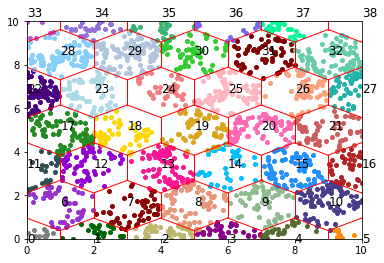

In [36]:
cell_plot(cells_xyt, cell_indices=True)
